In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


/home/martin/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Variable setup

In [3]:


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)


X_dim=1
Z_dim=10

#Input placeholder
X = tf.placeholder(tf.float32, shape=[None, X_dim])


#Discriminator variables
D_W1 = tf.Variable(xavier_init([X_dim, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

#Discriminator variable list
theta_D = [D_W1, D_W2, D_b1, D_b2]

#Input Noise placeholder
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

#Generator variables
G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

#Generator variable list
theta_G = [G_W1, G_W2, G_b1, G_b2]

# Model definitions

In [10]:
#Noise sampler
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.relu(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

# Model instantiation

In [11]:

G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)



# Data sampler

(100000, 1)


/home/martin/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


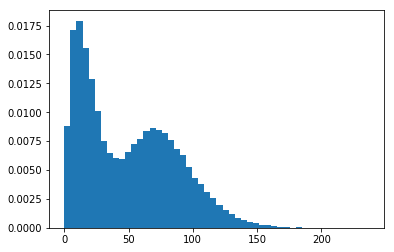

In [21]:
def sampleData(n_samples):
    b = np.random.binomial(n=1,p=0.5,size=n_samples)
    g1 = np.random.gamma(shape=2,scale=10,size=n_samples)
    g2 = np.random.gamma(shape=10,scale=8,size=n_samples)
    
#     plt.figure()
#     plt.hist(g1, normed=True, bins=50)
#     plt.hist(g2, normed=True, bins=50)
#     plt.show()
    return (b*g1+(1-b)*g2)[:,np.newaxis]
#     return np.random.gamma(shape=3,scale=10,size=n_samples)[:,np.newaxis]

gamma_samples = sampleData(100000)
print(gamma_samples.shape)
plt.hist(gamma_samples, normed=True, bins=50)
plt.show()

# Train and plot

In [ ]:
# batch size
mb_size = 128


sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('outGamma/'):
    os.makedirs('outGamma/')

i = 0

for it in range(1000000):
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={Z: sample_Z(1000, Z_dim)})
        fig = plt.figure()
        plt.hist(samples, normed=True, bins=50)
        plt.savefig('outGamma/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

#     X_mb, _ = mnist.train.next_batch(mb_size)
    X_mb = sampleData(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

/home/martin/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Iter: 0
D loss: 85.76
G_loss: 0.9033

Iter: 1000
D loss: 1.433
G_loss: 1.034

Iter: 2000
D loss: 1.312
G_loss: 0.8878

Iter: 3000
D loss: 1.456
G_loss: 0.6122

Iter: 4000
D loss: 1.391
G_loss: 0.7553

Iter: 5000
D loss: 1.374
G_loss: 0.6749

Iter: 6000
D loss: 1.421
G_loss: 0.7155

Iter: 7000
D loss: 1.393
G_loss: 0.8074

Iter: 8000
D loss: 1.387
G_loss: 0.7363

Iter: 9000
D loss: 1.4
G_loss: 0.8245

Iter: 10000
D loss: 1.386
G_loss: 0.6973

Iter: 11000
D loss: 1.385
G_loss: 0.6258

Iter: 12000
D loss: 1.393
G_loss: 0.7097

Iter: 13000
D loss: 1.396
G_loss: 0.7039

Iter: 14000
D loss: 1.391
G_loss: 0.591

Iter: 15000
D loss: 1.388
G_loss: 0.6862

Iter: 16000
D loss: 1.384
G_loss: 0.8068

Iter: 17000
D loss: 1.4
G_loss: 0.5609

Iter: 18000
D loss: 1.385
G_loss: 0.6336

Iter: 19000
D loss: 1.388
G_loss: 0.5756

Iter: 20000
D loss: 1.388
G_loss: 0.7497

Iter: 21000
D loss: 1.463
G_loss: 0.7423

Iter: 22000
D loss: 1.399
G_loss: 0.762

Iter: 23000
D loss: 1.404
G_loss: 0.6906

Iter: 24000


Iter: 195000
D loss: 1.412
G_loss: 0.8165

Iter: 196000
D loss: 1.396
G_loss: 0.7552

Iter: 197000
D loss: 1.391
G_loss: 0.6279

Iter: 198000
D loss: 1.399
G_loss: 0.8225

Iter: 199000
D loss: 1.387
G_loss: 0.6285

Iter: 200000
D loss: 1.39
G_loss: 0.5476

Iter: 201000
D loss: 1.388
G_loss: 0.7313

Iter: 202000
D loss: 1.395
G_loss: 0.7491

Iter: 203000
D loss: 1.391
G_loss: 0.8162

Iter: 204000
D loss: 1.39
G_loss: 0.6881

Iter: 205000
D loss: 1.386
G_loss: 0.8045

Iter: 206000
D loss: 1.419
G_loss: 0.6747

Iter: 207000
D loss: 1.386
G_loss: 0.8774

Iter: 208000
D loss: 1.388
G_loss: 0.6731

Iter: 209000
D loss: 1.371
G_loss: 0.5741

Iter: 210000
D loss: 1.397
G_loss: 0.7171

Iter: 211000
D loss: 1.402
G_loss: 0.8274

Iter: 212000
D loss: 1.395
G_loss: 0.839

Iter: 213000
D loss: 1.4
G_loss: 0.7216

Iter: 214000
D loss: 1.412
G_loss: 0.7388

Iter: 215000
D loss: 1.388
G_loss: 0.5843

Iter: 216000
D loss: 1.394
G_loss: 0.7246

Iter: 217000
D loss: 1.387
G_loss: 0.6142

Iter: 218000
D l

Iter: 387000
D loss: 1.389
G_loss: 0.7072

Iter: 388000
D loss: 1.367
G_loss: 0.7112

Iter: 389000
D loss: 1.267
G_loss: 0.6636

Iter: 390000
D loss: 1.375
G_loss: 0.7307

Iter: 391000
D loss: 1.413
G_loss: 0.6975

Iter: 392000
D loss: 1.388
G_loss: 0.6199

Iter: 393000
D loss: 1.39
G_loss: 0.6742

Iter: 394000
D loss: 1.434
G_loss: 0.8078

Iter: 395000
D loss: 1.459
G_loss: 0.8215

Iter: 396000
D loss: 1.394
G_loss: 0.6666

Iter: 397000
D loss: 1.419
G_loss: 0.7104

Iter: 398000
D loss: 1.385
G_loss: 0.6493

Iter: 399000
D loss: 1.387
G_loss: 0.6918

Iter: 400000
D loss: 1.39
G_loss: 0.7034

Iter: 401000
D loss: 1.398
G_loss: 0.7447

Iter: 402000
D loss: 1.386
G_loss: 0.7451

Iter: 403000
D loss: 1.431
G_loss: 0.6786

Iter: 404000
D loss: 1.394
G_loss: 0.6919

Iter: 405000
D loss: 1.382
G_loss: 0.6865

Iter: 406000
D loss: 1.386
G_loss: 0.6694

Iter: 407000
D loss: 1.389
G_loss: 0.6254

Iter: 408000
D loss: 1.41
G_loss: 0.7455

Iter: 409000
D loss: 1.39
G_loss: 0.7058

Iter: 410000
D 

Iter: 579000
D loss: 1.4
G_loss: 0.6857

Iter: 580000
D loss: 1.39
G_loss: 0.7164

Iter: 581000
D loss: 1.387
G_loss: 0.7153

Iter: 582000
D loss: 1.387
G_loss: 0.6613

Iter: 583000
D loss: 1.387
G_loss: 0.6887

Iter: 584000
D loss: 1.397
G_loss: 0.7212

Iter: 585000
D loss: 1.389
G_loss: 0.6528

Iter: 586000
D loss: 1.386
G_loss: 0.6414

Iter: 587000
D loss: 1.387
G_loss: 0.7249

Iter: 588000
D loss: 1.389
G_loss: 0.6834

Iter: 589000
D loss: 1.393
G_loss: 0.6162

Iter: 590000
D loss: 1.387
G_loss: 0.6904

Iter: 591000
D loss: 1.385
G_loss: 0.6488

Iter: 592000
D loss: 1.387
G_loss: 0.74

Iter: 593000
D loss: 1.387
G_loss: 0.7288

Iter: 594000
D loss: 1.385
G_loss: 0.6744

Iter: 595000
D loss: 1.387
G_loss: 0.708

Iter: 596000
D loss: 1.399
G_loss: 0.769

Iter: 597000
D loss: 1.386
G_loss: 0.6823

Iter: 598000
D loss: 1.388
G_loss: 0.7073

Iter: 599000
D loss: 1.39
G_loss: 0.7425

Iter: 600000
D loss: 1.405
G_loss: 0.6278

Iter: 601000
D loss: 1.394
G_loss: 0.6762

Iter: 602000
D loss

Iter: 771000
D loss: 1.404
G_loss: 0.7465

Iter: 772000
D loss: 1.4
G_loss: 0.6651

Iter: 773000
D loss: 1.38
G_loss: 0.5808

Iter: 774000
D loss: 1.396
G_loss: 0.7262

Iter: 775000
D loss: 1.384
G_loss: 0.7527

Iter: 776000
D loss: 1.4
G_loss: 0.6963

Iter: 777000
D loss: 1.389
G_loss: 0.688

Iter: 778000
D loss: 1.387
G_loss: 0.7238

Iter: 779000
D loss: 1.405
G_loss: 0.7196

Iter: 780000
D loss: 1.384
G_loss: 0.6799

Iter: 781000
D loss: 1.391
G_loss: 0.6718

Iter: 782000
D loss: 1.392
G_loss: 0.7126

Iter: 783000
D loss: 1.386
G_loss: 0.713

Iter: 784000
D loss: 1.396
G_loss: 0.7204

Iter: 785000
D loss: 1.386
G_loss: 0.7773

Iter: 786000
D loss: 1.387
G_loss: 0.6754

Iter: 787000
D loss: 1.386
G_loss: 0.6782

Iter: 788000
D loss: 1.386
G_loss: 0.7657

Iter: 789000
D loss: 1.389
G_loss: 0.728

Iter: 790000
D loss: 1.387
G_loss: 0.7443

Iter: 791000
D loss: 1.407
G_loss: 0.8205

Iter: 792000
D loss: 1.406
G_loss: 0.6184

Iter: 793000
D loss: 1.393
G_loss: 0.6529

Iter: 794000
D loss